# Electricity Consumption Prediction using RNN vs LSTM vs GRU

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchmetrics import MeanSquaredError

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## EDA

In [3]:
train_data = pd.read_csv('/content/electricity_train.csv')
test_data = pd.read_csv('/content/electricity_test.csv')

train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

In [ ]:
train_data.head()

,timestamp,consumption
0,2011-01-01 00:15:00,-0.704319
1,2011-01-01 00:30:00,-0.704319
2,2011-01-01 00:45:00,-0.678983
3,2011-01-01 01:00:00,-0.653647
4,2011-01-01 01:15:00,-0.704319


In [ ]:
print(train_data.duplicated().sum())
print(train_data['timestamp'].isna().sum())

0
0


### Exploring Time Features

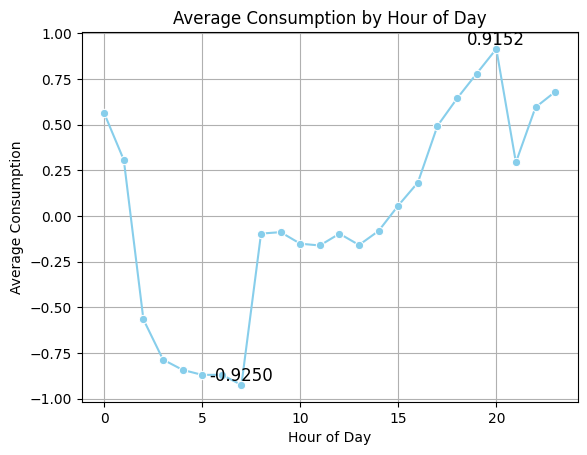

In [ ]:
train_data['hour'] = train_data['timestamp'].dt.hour
hour_consumption = train_data.groupby('hour')['consumption'].mean()

highest = hour_consumption.max()
lowest = hour_consumption.min()

highest_hour = hour_consumption.idxmax()
lowest_hour = hour_consumption.idxmin()

sns.lineplot(x=hour_consumption.index, y=hour_consumption.values, marker='o', color='skyblue')
plt.title('Average Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption')
plt.grid()

plt.text(highest_hour, highest, s=f'{highest:.4f}', fontsize=12, ha='center', va='bottom')
plt.text(lowest_hour, lowest, s=f'{lowest:.4f}', fontsize=12, ha='center', va='bottom')

plt.show()

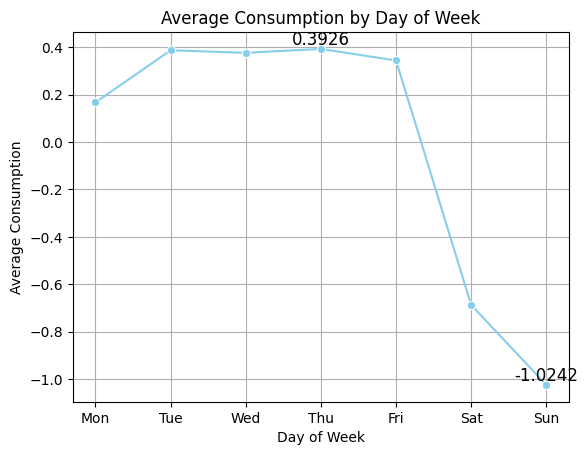

In [ ]:
train_data['day_of_week'] = train_data['timestamp'].dt.dayofweek
day_of_week_consumption = train_data.groupby('day_of_week')['consumption'].mean()

highest = day_of_week_consumption.max()
lowest = day_of_week_consumption.min()

highest_day_of_week = day_of_week_consumption.idxmax()
lowest_day_of_week = day_of_week_consumption.idxmin()

sns.lineplot(x=day_of_week_consumption.index, y=day_of_week_consumption.values, marker='o', color='skyblue')
plt.title('Average Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Consumption')
plt.grid()

plt.xticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.text(highest_day_of_week, highest, s=f'{highest:.4f}', fontsize=12, ha='center', va='bottom')
plt.text(lowest_day_of_week, lowest, s=f'{lowest:.4f}', fontsize=12, ha='center', va='bottom')

plt.show()

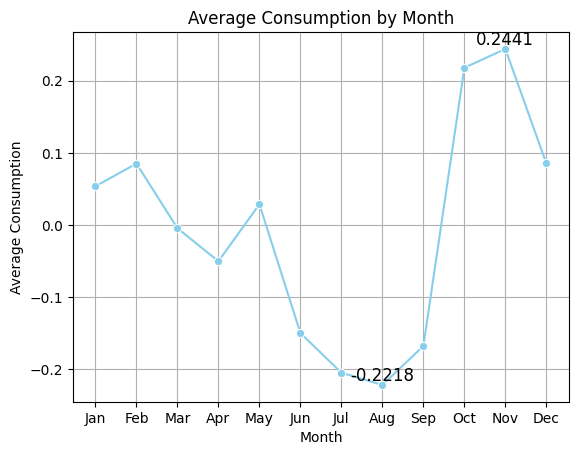

In [ ]:
train_data['month'] = train_data['timestamp'].dt.month
month_consumption = train_data.groupby('month')['consumption'].mean()

highest = month_consumption.max()
lowest = month_consumption.min()

highest_month = month_consumption.idxmax()
lowest_month = month_consumption.idxmin()

sns.lineplot(x=month_consumption.index, y=month_consumption.values, marker='o', color='skyblue')
plt.title('Average Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Consumption')
plt.grid()

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.text(highest_month, highest, s=f'{highest:.4f}', fontsize=12, ha='center', va='bottom')
plt.text(lowest_month, lowest, s=f'{lowest:.4f}', fontsize=12, ha='center', va='bottom')

plt.show()

## Prepare Data

My features are past electricity comsumption in 24 hours = 4 * 24 = 96

In [4]:
def create_sequences(df, seq_length):
		xs, ys = [], []
		for i in range(len(df) - seq_length):
				x = df.iloc[i:(i+seq_length), 1]
				y = df.iloc[i+seq_length, 1]
				xs.append(x)
				ys.append(y)
		return np.array(xs), np.array(ys)

seq_length = 24*4

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
print(f'Shape of Train data: {X_train.shape}, {y_train.shape}')
print(f'Shape of Test data: {X_test.shape}, {y_test.shape}')

Shape of Train data: (105119, 96), (105119,)
Shape of Test data: (34944, 96), (34944,)


In [5]:
dataset_train_val = TensorDataset(
		torch.from_numpy(X_train).float(),
		torch.from_numpy(y_train).float()
)

dataset_test = TensorDataset(
		torch.from_numpy(X_test).float(),
		torch.from_numpy(y_test).float()
)

In [6]:
train_size = int(0.9 * len(dataset_train_val))
val_size = len(dataset_train_val) - train_size
train_dataset, val_dataset = random_split(dataset_train_val, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle = True)

## Data Prediction

### RNN

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [8]:
class Net_RNN(nn.Module):
		def __init__(self):
				super().__init__()
				self.rnn = nn.RNN(
						input_size = 1, # 1 feature
						hidden_size = 32,
						num_layers = 2,
						batch_first = True,
						dropout=0.2
				)
				self.fc = nn.Linear(32, 1)

		def forward(self, x):
				h0 = torch.zeros(self.rnn.num_layers, x.size(0), 32).to(x.device) # initialize first hidden state to zeros
				out, _ = self.rnn(x, h0)
				out = self.fc(out[:, -1, :]) # select last RNN's output and pass it through linear layer
				return out

net_RNN = Net_RNN().to(device)

In [9]:
criterion_RNN = nn.MSELoss()
optimizer_RNN = optim.Adam(net_RNN.parameters(), lr=0.0001)

In [10]:
# Early stopping parameters
patience = 5 # Number of epochs to wait before stopping
min_val_loss = float('inf') # Initialize with a very high value
count = 0 # Tracks how many epochs the val_loss hasn't improved
best_model_state = None

# epoch
num_epochs_RNN = 20
train_loss_RNN = []
val_loss_RNN = []

In [11]:
for epoch in range(num_epochs_RNN):
    net_RNN.train()
    training_loss = 0.0

    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)

        optimizer_RNN.zero_grad()
        seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

        outputs = net_RNN(seqs)
        loss = criterion_RNN(outputs, labels.view(-1, 1))

        loss.backward()
        optimizer_RNN.step()
        training_loss += loss.item()

    epoch_train_loss = training_loss / len(train_loader)
    train_loss_RNN.append(epoch_train_loss)

    # Validation Phase
    net_RNN.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for seqs, labels in val_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

            outputs = net_RNN(seqs)
            loss = criterion_RNN(outputs, labels.view(-1, 1))
            validation_loss += loss.item()

    epoch_val_loss = validation_loss / len(val_loader)
    val_loss_RNN.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs_RNN} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        count = 0
        best_model_state = net_RNN.state_dict()
    else:
        count += 1
        if count >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {min_val_loss:.4f} at Epoch: {epoch}/{num_epochs_RNN}")
            break

Epoch 1/20 - Train Loss: 0.1041, Val Loss: 0.0573
Epoch 2/20 - Train Loss: 0.0634, Val Loss: 0.0564
Epoch 3/20 - Train Loss: 0.0616, Val Loss: 0.0551
Epoch 4/20 - Train Loss: 0.0598, Val Loss: 0.0537
Epoch 5/20 - Train Loss: 0.0583, Val Loss: 0.0527
Epoch 6/20 - Train Loss: 0.0570, Val Loss: 0.0522
Epoch 7/20 - Train Loss: 0.0560, Val Loss: 0.0512
Epoch 8/20 - Train Loss: 0.0551, Val Loss: 0.0513
Epoch 9/20 - Train Loss: 0.0542, Val Loss: 0.0503
Epoch 10/20 - Train Loss: 0.0535, Val Loss: 0.0495
Epoch 11/20 - Train Loss: 0.0527, Val Loss: 0.0491
Epoch 12/20 - Train Loss: 0.0518, Val Loss: 0.0484
Epoch 13/20 - Train Loss: 0.0512, Val Loss: 0.0480
Epoch 14/20 - Train Loss: 0.0506, Val Loss: 0.0481
Epoch 15/20 - Train Loss: 0.0502, Val Loss: 0.0472
Epoch 16/20 - Train Loss: 0.0496, Val Loss: 0.0477
Epoch 17/20 - Train Loss: 0.0496, Val Loss: 0.0469
Epoch 18/20 - Train Loss: 0.0491, Val Loss: 0.0469
Epoch 19/20 - Train Loss: 0.0486, Val Loss: 0.0464
Epoch 20/20 - Train Loss: 0.0483, Val Lo

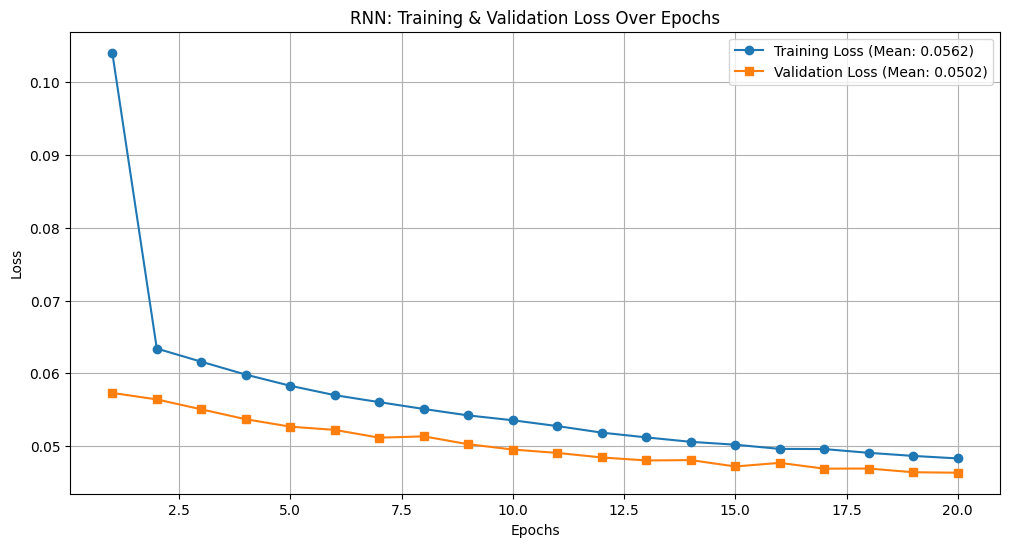

In [12]:
mean_train_loss_RNN = sum(train_loss_RNN) / len(train_loss_RNN)
mean_val_loss_RNN = sum(val_loss_RNN) / len(val_loss_RNN)

# Plot the Loss Curve
if num_epochs_RNN > epoch + 1:
    range_epoch = epoch
else: range_epoch = num_epochs_RNN

plt.figure(figsize = (12, 6))
plt.plot(range(1, range_epoch + 1), train_loss_RNN, label=f'Training Loss (Mean: {mean_train_loss_RNN:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss_RNN, label=f'Validation Loss (Mean: {mean_val_loss_RNN:.4f})', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN: Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [13]:
if best_model_state:
    net_RNN.load_state_dict(best_model_state)

In [14]:
mse_RNN = MeanSquaredError().to(device)
testing_loss = 0.0

net_RNN.eval()
with torch.no_grad():
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)
        outputs = net_RNN(seqs).squeeze()

        mse_RNN.update(outputs, labels) # accumulate
        loss = criterion_RNN(outputs, labels.view(-1, 1))
        testing_loss += loss.item()

avg_test_loss = testing_loss / len(test_loader)
test_mse_RNN = mse_RNN.compute() # average

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test MSE: {test_mse_RNN:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 1.1765
Test MSE: 0.0457


### LSTM

In [15]:
class Net_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,  # 1 feature
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_LSTM = Net_LSTM().to(device)

In [16]:
criterion_LSTM = nn.MSELoss()
optimizer_LSTM = optim.Adam(net_LSTM.parameters(), lr=0.0001)

In [17]:
# Early stopping parameters
patience = 5
min_val_loss = float('inf')
count = 0
best_model_state = None

# epoch
num_epochs_LSTM = 20
train_loss_LSTM = []
val_loss_LSTM = []

In [18]:
for epoch in range(num_epochs_LSTM):
    net_LSTM.train()
    training_loss = 0.0

    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)

        optimizer_LSTM.zero_grad()
        seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

        outputs = net_LSTM(seqs)
        loss = criterion_LSTM(outputs, labels.view(-1, 1))

        loss.backward()
        optimizer_LSTM.step()
        training_loss += loss.item()

    epoch_train_loss = training_loss / len(train_loader)
    train_loss_LSTM.append(epoch_train_loss)

    # Validation Phase
    net_LSTM.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for seqs, labels in val_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

            outputs = net_LSTM(seqs)
            loss = criterion_LSTM(outputs, labels.view(-1, 1))
            validation_loss += loss.item()

    epoch_val_loss = validation_loss / len(val_loader)
    val_loss_LSTM.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs_LSTM} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        count = 0
        best_model_state = net_LSTM.state_dict()
    else:
        count += 1
        if count >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {min_val_loss:.4f} at Epoch: {epoch}/{num_epochs_LSTM}")
            break

Epoch 1/20 - Train Loss: 0.1743, Val Loss: 0.0602
Epoch 2/20 - Train Loss: 0.0667, Val Loss: 0.0529
Epoch 3/20 - Train Loss: 0.0590, Val Loss: 0.0510
Epoch 4/20 - Train Loss: 0.0551, Val Loss: 0.0488
Epoch 5/20 - Train Loss: 0.0522, Val Loss: 0.0501
Epoch 6/20 - Train Loss: 0.0503, Val Loss: 0.0463
Epoch 7/20 - Train Loss: 0.0486, Val Loss: 0.0462
Epoch 8/20 - Train Loss: 0.0474, Val Loss: 0.0454
Epoch 9/20 - Train Loss: 0.0465, Val Loss: 0.0449
Epoch 10/20 - Train Loss: 0.0455, Val Loss: 0.0437
Epoch 11/20 - Train Loss: 0.0443, Val Loss: 0.0440
Epoch 12/20 - Train Loss: 0.0439, Val Loss: 0.0427
Epoch 13/20 - Train Loss: 0.0435, Val Loss: 0.0424
Epoch 14/20 - Train Loss: 0.0431, Val Loss: 0.0428
Epoch 15/20 - Train Loss: 0.0429, Val Loss: 0.0419
Epoch 16/20 - Train Loss: 0.0424, Val Loss: 0.0414
Epoch 17/20 - Train Loss: 0.0420, Val Loss: 0.0414
Epoch 18/20 - Train Loss: 0.0419, Val Loss: 0.0415
Epoch 19/20 - Train Loss: 0.0416, Val Loss: 0.0407
Epoch 20/20 - Train Loss: 0.0412, Val Lo

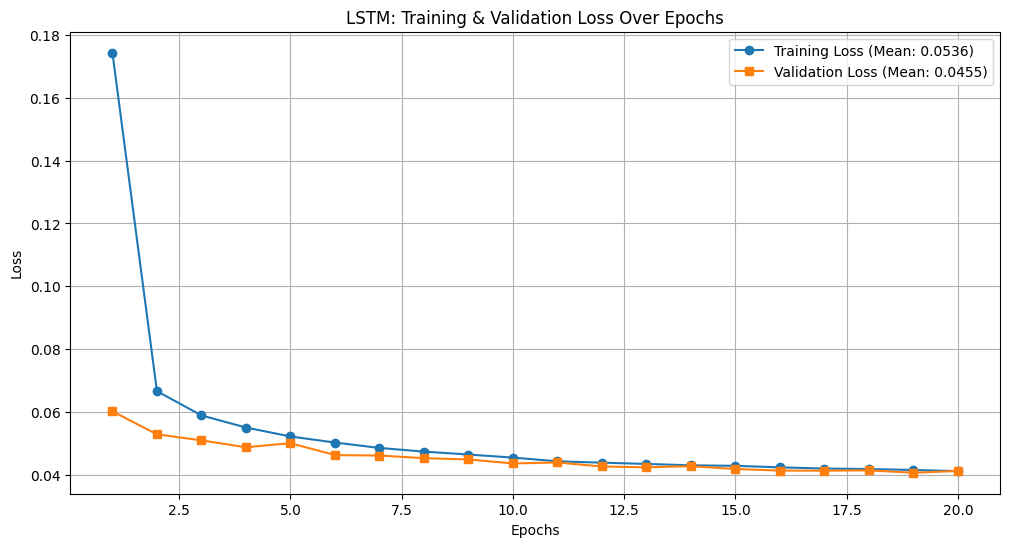

In [19]:
mean_train_loss_LSTM = sum(train_loss_LSTM) / len(train_loss_LSTM)
mean_val_loss_LSTM = sum(val_loss_LSTM) / len(val_loss_LSTM)

# Plot the Loss Curve
if num_epochs_LSTM > epoch + 1:
    range_epoch = epoch
else: range_epoch = num_epochs_LSTM

plt.figure(figsize = (12, 6))
plt.plot(range(1, range_epoch + 1), train_loss_LSTM, label=f'Training Loss (Mean: {mean_train_loss_LSTM:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss_LSTM, label=f'Validation Loss (Mean: {mean_val_loss_LSTM:.4f})', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM: Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [20]:
if best_model_state:
    net_LSTM.load_state_dict(best_model_state)

In [21]:
mse_LSTM = MeanSquaredError().to(device)
testing_loss = 0.0

net_LSTM.eval()
with torch.no_grad():
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)
        outputs = net_LSTM(seqs).squeeze()

        mse_LSTM.update(outputs, labels) # accumulate
        loss = criterion_LSTM(outputs, labels.view(-1, 1))
        testing_loss += loss.item()

avg_test_loss = testing_loss / len(test_loader)
test_mse_LSTM = mse_LSTM.compute() # average

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test MSE: {test_mse_LSTM:.4f}")

Test Loss: 1.1211
Test MSE: 0.0574


### GRU

In [22]:
class Net_GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(
            input_size=1,  # 1 feature
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

net_GRU = Net_GRU().to(device)

In [23]:
criterion_GRU = nn.MSELoss()
optimizer_GRU = optim.Adam(net_GRU.parameters(), lr=0.0001)

In [25]:
# Early stopping parameters
patience = 5
min_val_loss = float('inf')
count = 0
best_model_state = None

# epoch
num_epochs_GRU = 20
train_loss_GRU = []
val_loss_GRU = []

In [26]:
for epoch in range(num_epochs_GRU):
    net_GRU.train()
    training_loss = 0.0

    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)

        optimizer_GRU.zero_grad()
        seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

        outputs = net_GRU(seqs)
        loss = criterion_GRU(outputs, labels.view(-1, 1))

        loss.backward()
        optimizer_GRU.step()
        training_loss += loss.item()

    epoch_train_loss = training_loss / len(train_loader)
    train_loss_GRU.append(epoch_train_loss)

    # Validation Phase
    net_GRU.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for seqs, labels in val_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

            outputs = net_GRU(seqs)
            loss = criterion_GRU(outputs, labels.view(-1, 1))
            validation_loss += loss.item()

    epoch_val_loss = validation_loss / len(val_loader)
    val_loss_GRU.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs_GRU} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        count = 0
        best_model_state = net_GRU.state_dict()
    else:
        count += 1
        if count >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {min_val_loss:.4f} at Epoch: {epoch}/{num_epochs_GRU}")
            break

Epoch 1/20 - Train Loss: 0.1284, Val Loss: 0.0572
Epoch 2/20 - Train Loss: 0.0656, Val Loss: 0.0554
Epoch 3/20 - Train Loss: 0.0616, Val Loss: 0.0539
Epoch 4/20 - Train Loss: 0.0591, Val Loss: 0.0524
Epoch 5/20 - Train Loss: 0.0571, Val Loss: 0.0516
Epoch 6/20 - Train Loss: 0.0553, Val Loss: 0.0504
Epoch 7/20 - Train Loss: 0.0536, Val Loss: 0.0494
Epoch 8/20 - Train Loss: 0.0524, Val Loss: 0.0483
Epoch 9/20 - Train Loss: 0.0512, Val Loss: 0.0478
Epoch 10/20 - Train Loss: 0.0504, Val Loss: 0.0479
Epoch 11/20 - Train Loss: 0.0496, Val Loss: 0.0480
Epoch 12/20 - Train Loss: 0.0488, Val Loss: 0.0464
Epoch 13/20 - Train Loss: 0.0482, Val Loss: 0.0461
Epoch 14/20 - Train Loss: 0.0475, Val Loss: 0.0466
Epoch 15/20 - Train Loss: 0.0471, Val Loss: 0.0455
Epoch 16/20 - Train Loss: 0.0465, Val Loss: 0.0456
Epoch 17/20 - Train Loss: 0.0462, Val Loss: 0.0451
Epoch 18/20 - Train Loss: 0.0456, Val Loss: 0.0476
Epoch 19/20 - Train Loss: 0.0452, Val Loss: 0.0445
Epoch 20/20 - Train Loss: 0.0448, Val Lo

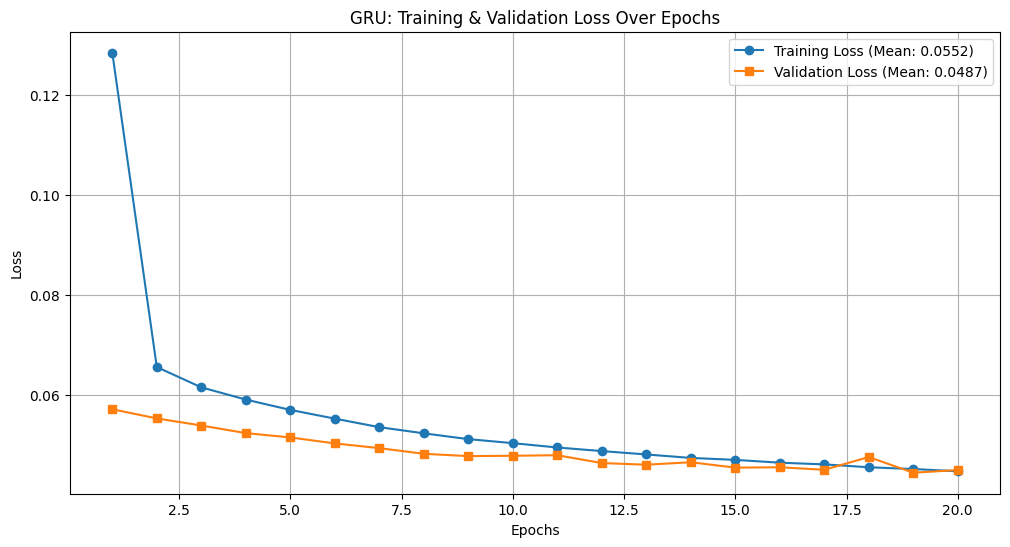

In [27]:
mean_train_loss_GRU = sum(train_loss_GRU) / len(train_loss_GRU)
mean_val_loss_GRU = sum(val_loss_GRU) / len(val_loss_GRU)

# Plot the Loss Curve
if num_epochs_GRU > epoch + 1:
    range_epoch = epoch
else: range_epoch = num_epochs_GRU

plt.figure(figsize = (12, 6))
plt.plot(range(1, range_epoch + 1), train_loss_GRU, label=f'Training Loss (Mean: {mean_train_loss_GRU:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss_GRU, label=f'Validation Loss (Mean: {mean_val_loss_GRU:.4f})', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU: Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [28]:
if best_model_state:
    net_GRU.load_state_dict(best_model_state)

In [29]:
mse_GRU = MeanSquaredError().to(device)
testing_loss = 0.0

net_GRU.eval()
with torch.no_grad():
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)
        outputs = net_GRU(seqs).squeeze()

        mse_GRU.update(outputs, labels) # accumulate
        loss = criterion_GRU(outputs, labels.view(-1, 1))
        testing_loss += loss.item()

avg_test_loss = testing_loss / len(test_loader)
test_mse_GRU = mse_GRU.compute() # average

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test MSE: {test_mse_GRU:.4f}")

Test Loss: 1.1567
Test MSE: 0.0415
